**Set data path**

In [1]:
path = "measurements/Participant_test1/"

## Start postprocessing

- `isoforce_iso` contains the data recorded with the Isoforce
- `isoforce_py_raw` contains the Isoforce data recorded with the Python script
- `sciospec_EIT_raw` contains the EIT data recorded with the EIT device

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from src.postprocessing import (
    IsoforceIso,
    ProcessingDir,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
)

In [3]:
part_path = ProcessingDir(path)

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [4]:
DF = renderDF(part_path.isoforce_iso)

!!!The torque data was LP filtered!!!


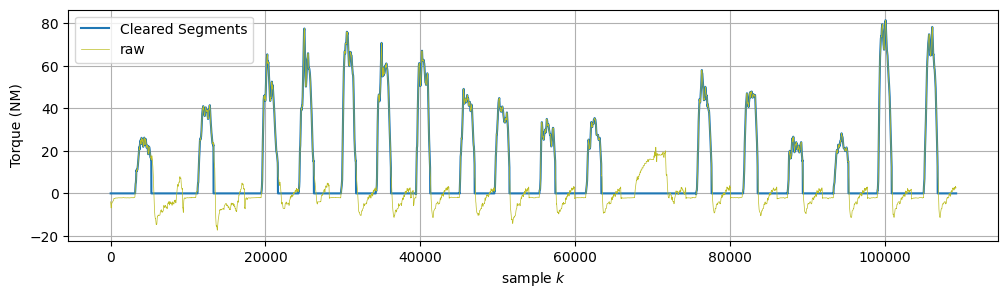

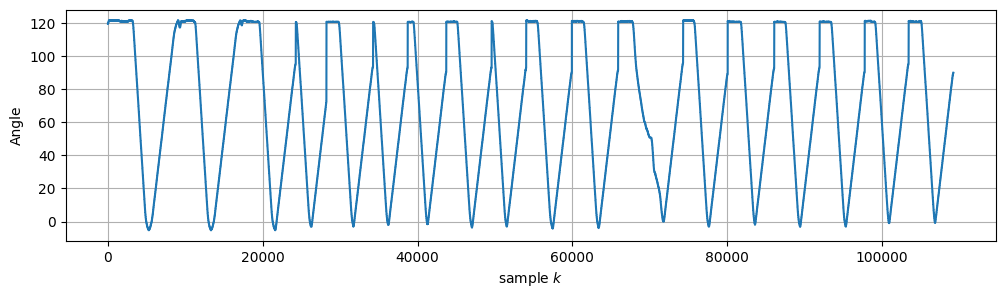

In [5]:
isoforce_iso = IsoforceIso(DF, LP_filter=True)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
# isoforce_iso.plot_velocity()

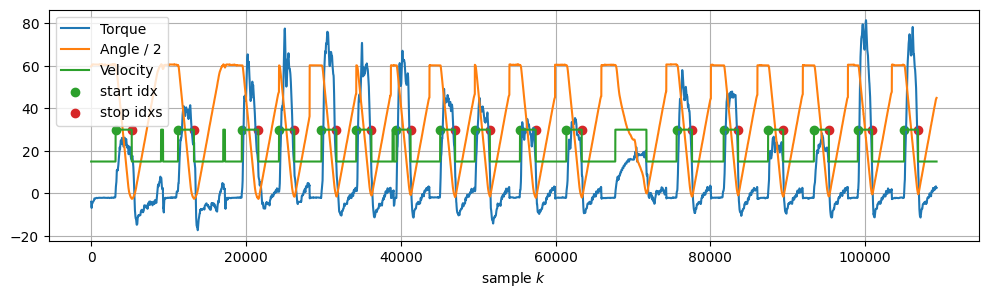

In [6]:
isoforce_iso.plot_data()

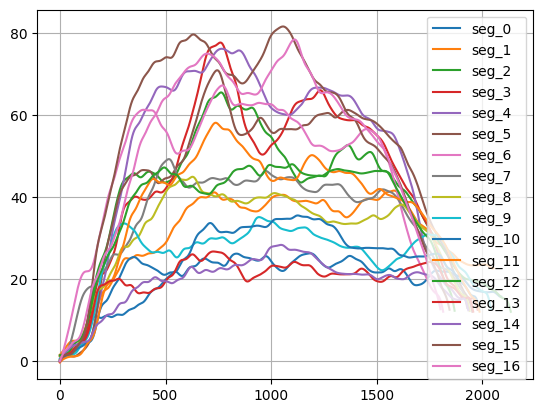

In [7]:
for key in isoforce_iso.torque_segments.keys():
    plt.plot(isoforce_iso.torque_segments[key], label=key)
    # print(np.round(np.mean(isoforce_iso.torque_segments[key])))
plt.legend()
plt.grid()
plt.show()

**Filter torque with velocity**

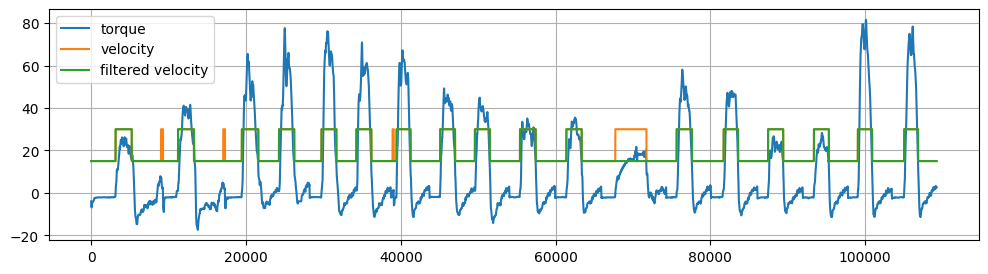

In [8]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(isoforce_iso.torque, label="torque")
plt.plot(isoforce_iso.velocity, label="velocity")
plt.plot(isoforce_iso.exclude_window * 15 + 15, label="filtered velocity")
plt.legend()
plt.show()

In [9]:
np.allclose(isoforce_iso.torque_raw, isoforce_iso.torque)

False

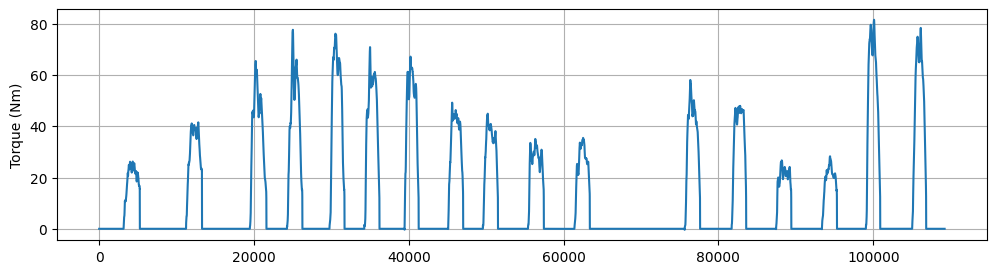

In [10]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(isoforce_iso.torque_seg)
plt.ylabel("Torque (Nm)")
plt.show()

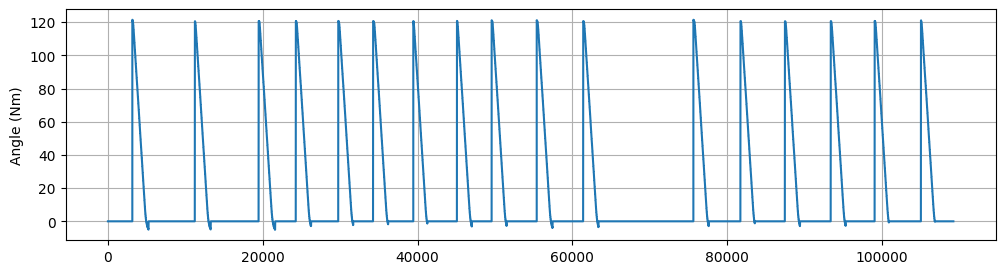

In [11]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(isoforce_iso.angle * isoforce_iso.exclude_window)
plt.ylabel("Angle (Nm)")
plt.show()

**EIT Sciospec raw**

In [12]:
part_path.print_info()

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [13]:
try:
    os.mkdir(part_path.s_path_eit)
    process_sciospec_eit(part_path)
except BaseException:
    print("Directory already exists.")

Directory already exists.


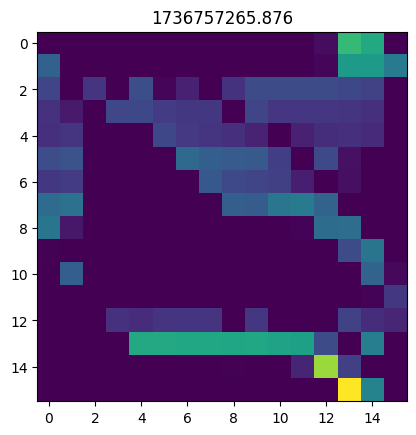

In [14]:
tmp = np.load(part_path.s_path_eit + "setup_00002.npz", allow_pickle=True)
tmp_2 = np.load(part_path.s_path_eit + "setup_00003.npz", allow_pickle=True)
tmp.files

plt.title(tmp["timestamp"])
plt.imshow(np.abs(tmp["eit"]))
plt.show()

**Isoforce Python raw**

- Ch_1, P = Position = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

In [15]:
part_path.isoforce_py_raw

'measurements/Participant_test1/Isokinetic_raw/'

In [16]:
from src.postprocessing import IsoforcePy

In [17]:
isoforce_py = IsoforcePy(part_path.isoforce_py_raw, LP_filter=True, over_UTC=False)

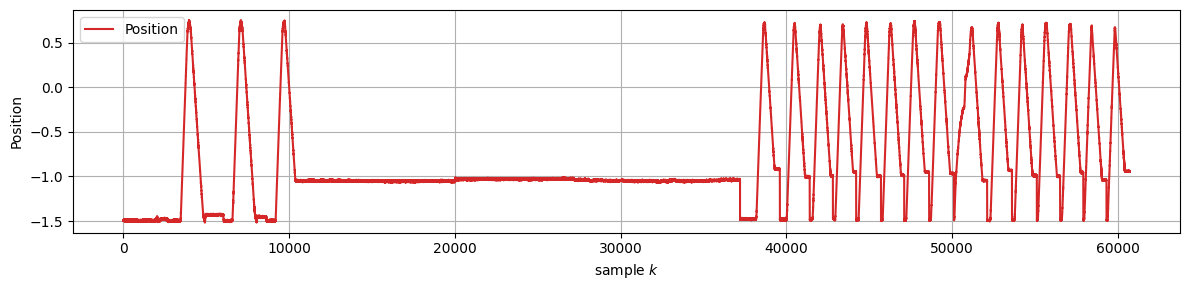

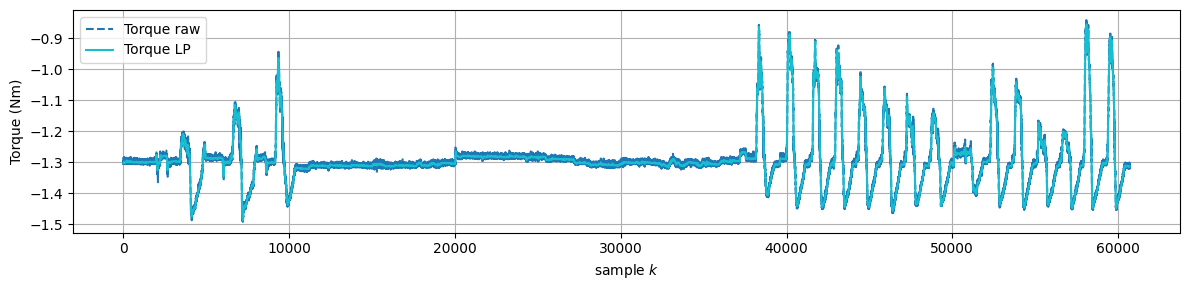

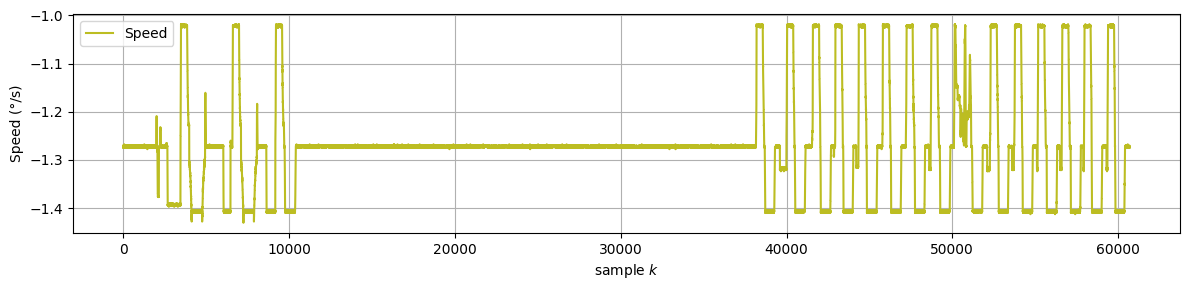

In [18]:
isoforce_py.plot_angle()
isoforce_py.plot_torque()
isoforce_py.plot_velocity()

- Ch_1, P = Position = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

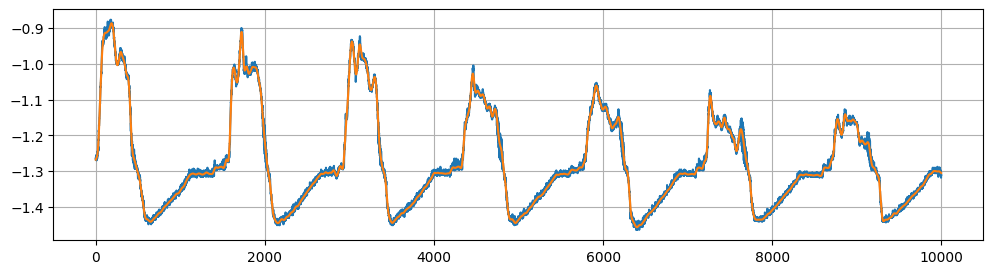

In [19]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.all_torque[40_000:50_000]))
plt.plot((isoforce_py.all_torque_LP[40_000:50_000]))
plt.grid()

**Sync `isoforce_iso` with `isoforce_py`**

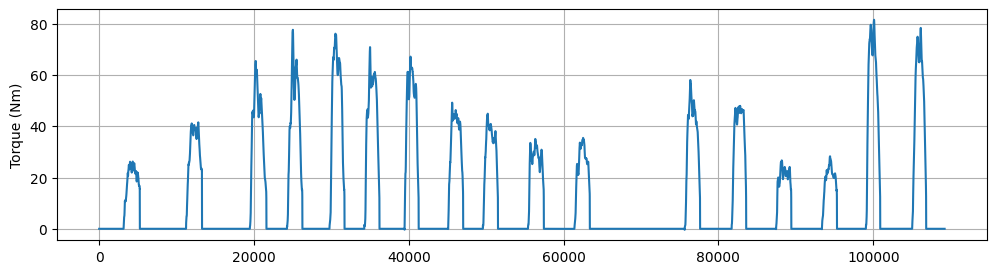

In [20]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(isoforce_iso.torque_seg)
plt.ylabel("Torque (Nm)")
plt.show()

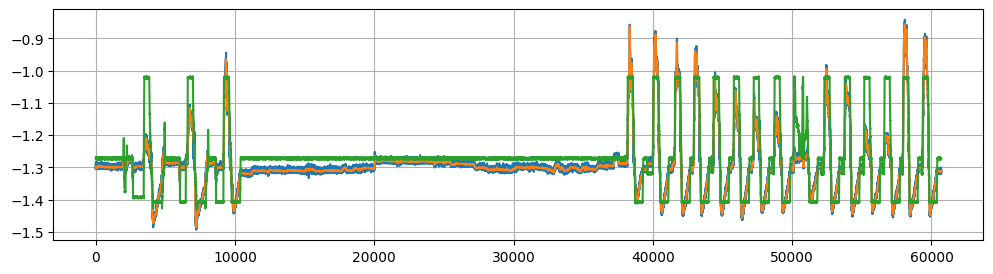

In [21]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.all_torque[:]))
plt.plot((isoforce_py.all_torque_LP[:]))
plt.plot(isoforce_py.all_speed)
plt.grid()

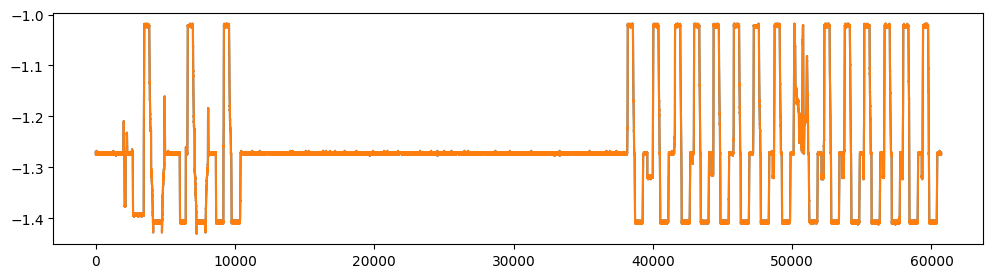

In [157]:
plt.figure(figsize=(12, 3))
plt.plot(isoforce_py.all_speed)
plt.plot(isoforce_py.all_speed)

In [137]:
speed_py = isoforce_py.all_speed
torque_py = isoforce_py.all_torque_LP
position_py = isoforce_py.all_position

In [138]:
from src.postprocessing import lowpass_filter, scale_to_range
from scipy.signal import find_peaks


def rising_edge_detection(signal):
    signal = np.asarray(signal)
    diff = np.diff(signal)
    rising_edges = np.where(diff == 1)[0]
    return rising_edges

In [139]:
# speed_py = scale_to_range(speed_py)
torque_py = scale_to_range(torque_py)

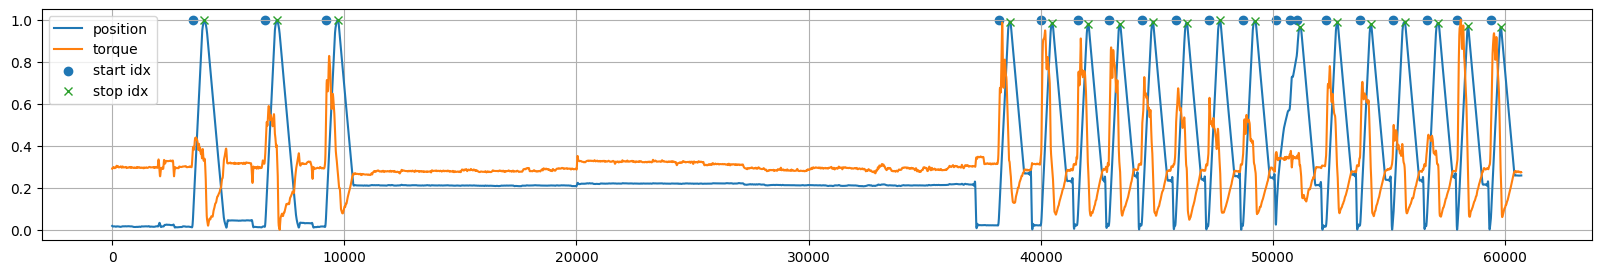

In [154]:
scaling_factor = 350
position_py = scale_to_range(lowpass_filter(position_py))
position_scaled = position_py * scaling_factor

k = np.arange(len(position_scaled))
dpos_dk = np.round(np.gradient(position_scaled, k))
dpos_dk[dpos_dk <= 0] = 0
dpos_dk[dpos_dk > 1] = 1
dpos_dk = np.round(dpos_dk)

start_idxs = rising_edge_detection(dpos_dk)
stop_idxs, _ = find_peaks(position_py, height=0.9)

# to_short = np.where(stop_idxs - start_idxs < 100)[0]
# to_long = np.where(stop_idxs - start_idxs > 2500)[0]
# cut_out = np.concatenate([to_short, to_long])
# stop_idxs = np.delete(stop_idxs,cut_out)
# start_idxs = np.delete(start_idxs,cut_out)

plt.figure(figsize=(20, 3))
startseg = 0_000
stopseg = 10_000
plt.plot(position_py, label="position")
plt.plot(torque_py, label="torque")
# plt.plot(dpos_dk)

plt.scatter(start_idxs, np.ones(len(start_idxs)), label="start idx")
plt.plot(stop_idxs, position_py[stop_idxs], "x", label="stop idx")

plt.legend()
plt.grid()

In [155]:
print(len(start_idxs), len(stop_idxs))

20 18


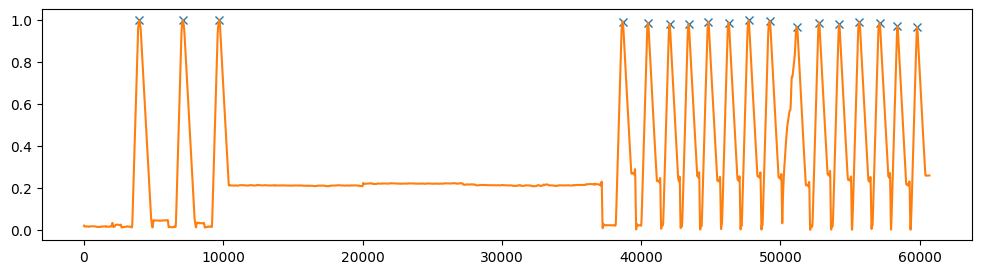

In [129]:
plt.figure(figsize=(12, 3))
plt.plot(peaks, position_py[peaks], "x")
plt.plot(position_py)
plt.show()

In [113]:
dpos_risedge

array([ 3460,  6590,  9188, 38180, 39537, 39651, 40016, 41579, 42940,
       44140, 44251, 44348, 45805, 47221, 48540, 48651, 48717, 50041,
       50135, 50729, 51029, 52297, 53540, 53653, 53761, 55148, 56617,
       57946, 59351])

In [84]:
start_idxs.shape

(3911,)

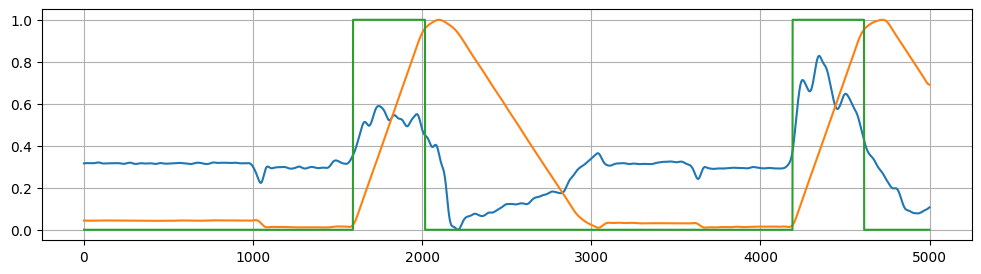

In [68]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(torque_py[startseg:stopseg])
plt.plot(lowpass_filter(position_py[startseg:stopseg]))
plt.plot(dpos_dk[startseg:stopseg])

**Value alignment**

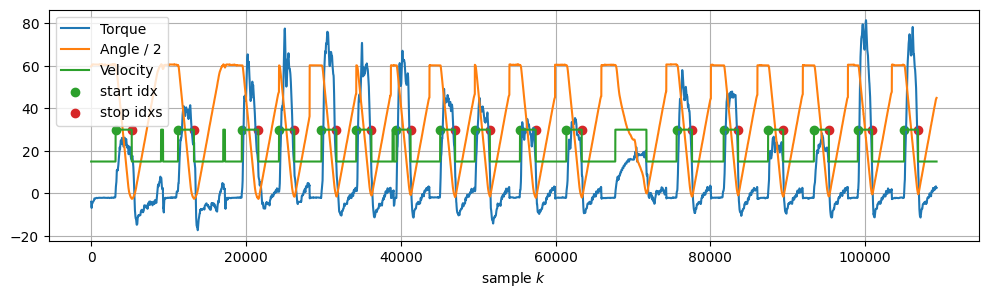

In [69]:
isoforce_iso.plot_data()

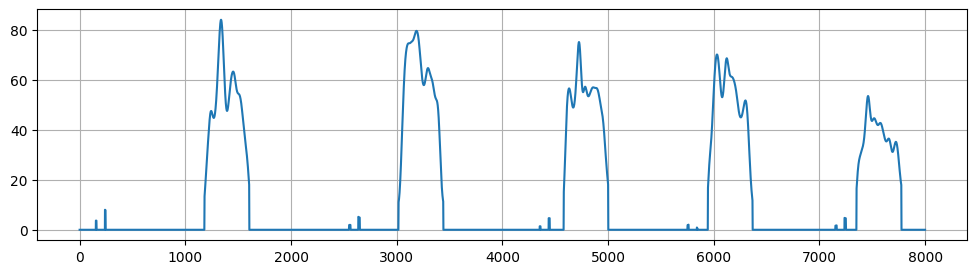

In [80]:
plt.figure(figsize=(12, 3))
plt.plot(
    (scale_to_range(isoforce_py.all_torque_LP[37000:45000]) * 108 - 24)
    * dpos_dk[37000:45000]
)
plt.grid()